In [2]:
using CSV, DataFrames; ENV["COLUMNS"]=160 # for displaying more columns of a dataframe
using LinearAlgebra, StaticArrays
using BenchmarkTools
using Plots, LaTeXStrings; pyplot(); default(framestyle = :box, minorticks = 5, fg_color_legend = :lightgray);
using QuadGK; using Interpolations

In [ ]:
using Pkg
Pkg.add(PackageSpec(url="https://github.com/fkguo/IMinuit.jl"))

In [ ]:
using IMinuit

In [3]:
const unit = 1.0;
const fpi = 92.21unit; const mpic = 139.57018unit; const mpi0 = 134.9766unit;
const meta = 547.862unit; const mkc = 493.677unit; const mk0 = 497.614unit;
const mpi = (2mpic + mpi0)/3; const mk = (mkc + mk0)/2
const μ = 770.0unit;
const ϵ = eps();

# best fit parameters from Gomez Nicola, Pelaez
const lecr0 = [0.56e-3, 1.21e-3, -2.79e-3, -0.36e-3, 1.4e-3, 0.07e-3, -0.44e-3, 0.78e-3];

# NLO CHPT LECs
const lec_chpt = (0.4e-3, 1.35e-3, -3.5e-3, -0.3e-3, 1.4e-3, -0.2e-3, -0.4e-3, 0.9e-3)

const paras0 = [lecr0..., 1e-4];

# Data

The data for the 00 wave up to 970 MeV are taken from the table in the appendix of the GKPRY paper:

*The Pion-pion scattering amplitude. IV: Improved analysis with once subtracted Roy-like equations up to 1100 MeV*
 R. Garcia-Martin, R. Kaminski, J.R. Pelaez, J. Ruiz de Elvira, F.J. Yndurain, [Phys.Rev.D 83 (2011) 074004](https://doi.org/10.1103/PhysRevD.83.074004) [[1102.2183 [hep-ph]](https://arxiv.org/abs/1102.2183)]
The data points on $\delta_0^0$ above 970 MeV and $\eta_0^0$ taken read off from Figs. 15 and 17, respectively:

<img src="./datajl/pipi00_Roy-GKPY_PRD83_074004.png" style="height: 250px;"/>  <img src="./datajl/eta00_Roy-GKPY_PRD83_074004.png" style="height: 250px;"/> 

I tried to take data for the 11 and 20 waves above 970 MeV from:
*The Pion-pion scattering amplitude. III. Improving the analysis with forward dispersion relations and Roy equations*
R. Kaminski, J.R. Pelaez, F.J. Yndurain, [Phys.Rev.D 77 (2008) 054015](https://doi.org/10.1103/PhysRevD.77.054015) [[0710.1150 [hep-ph]](https://arxiv.org/abs/0710.1150)]

<img src="./datajl/pipi11_Roy-KPY_PRD77_054015.png" style="height: 250px;"/>  <img src="./datajl/pipi20_Roy-KPY_PRD77_054015.png" style="height: 250px;"/> 

However, the $\delta_0^2$ values do not match: the central value at 970 MeV in the figure is apperantly larger than that givein in the table. $\delta_1^1$ is roughly okay.

In [4]:
# data from the GKPRY paper
data_GKPRY_ππ00_df = DataFrame!(CSV.File("./datajl/pipi/pipi00_Roy-GKPY_PRD83_074004.dat", header = [:w, :δ, :err], 
        delim=' ', ignorerepeated=true))
data_GKPRY_ππ11_df = DataFrame!(CSV.File("./datajl/pipi/pipi11_Roy-GKPY_PRD83_074004.dat", header = [:w, :δ, :err], 
        delim=' ', ignorerepeated=true))
data_GKPRY_ππ20_df = DataFrame!(CSV.File("./datajl/pipi/pipi20_Roy-GKPY_PRD83_074004.dat", header = [:w, :δ, :err], 
        delim=' ', ignorerepeated=true))
data_GKPRY_ππ00_eta_df = DataFrame!(CSV.File("./datajl/pipikk/eta00_Roy-GKPY_PRD83_074004.dat", header = [:w, :η, :err], 
        delim=' ', ignorerepeated=true));
# join(data_GKPRY_ππ00_df, data_GKPRY_ππ11_df, data_GKPRY_ππ20_df, on = :w, makeunique=true)

In [5]:
# Cohen et al., PRD22,2595 (1980)
data_ππkk00_Cohen_df = DataFrame!(CSV.File("./datajl/pipikk/pipikk-Cohen-PRD22_2595.dat", header = [:w, :δ, :err], 
        delim='\t', ignorerepeated=true))
# Martin and Ozmutlu, NPB158,520 (1979); 9 points below 1.2 GeV
data_ππkk00_Martin_df = DataFrame!(CSV.File("./datajl/pipikk/pipikk-Martin-NPB158_520.dat", header = [:w, :δ, :err],
        delim='\t', ignorerepeated=true));

# recommended inelasticity data by Jose. 
# from Kaminski, Leniak, Rybicki, Z.Phys.C 74 (1997) 79-91, https://inspirehep.net/literature/419770
# 30 points below 1.2 GeV
data_ππ00_eta_Kaminski_df = DataFrame!(CSV.File("./datajl/pipikk/S0ine-Kaminski-ZPC74_79.dat", 
        header = [:w, :η, :err], delim='\t', ignorerepeated=true));

In [283]:
# Armstrong et al. [WA76], Z.Phys.C 52 (1991) 389-396
data_πη_WA76_df = DataFrame!(CSV.File("./datajl/pieta_ZPC52_389.csv", header = [:w, :y, :err]));
# interpolate the background extracted from data
data_πη_WA76_bg_df = sort(DataFrame!(CSV.File("./datajl/pieta_bg_ZPC52_389.csv", header = [:w, :y])), :w)
const data_πη_WA76_bg = LinearInterpolation(data_πη_WA76_bg_df.w, data_πη_WA76_bg_df.y);

In [6]:
# S-wave Kπ scattering phase shifts
# Aston et al, NPB296, 493; 21 points below 1.2 GeV
data_πK10_Aston_df = DataFrame!(CSV.File("./datajl/kpi/S-Aston-PhaseShift-New.dat", 
        header = [:w, :δ, :err], delim="\t", ignorerepeated=true))
# Estabrooks et al., NPB133, 490; 19 points below 1.2 GeV
data_πK10_Estabrooks_df = DataFrame!(CSV.File("./datajl/kpi/S-Estabrooks-PhaseShift-New.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true));
# Mercer et al., NPB32, 381; 14 points below 1.2 GeV
data_πK10_Mercer_df = DataFrame!(CSV.File("./datajl/kpi/S-Mercer-PhaseShift-NPB32_381.dat", 
        header = [:w, :δ, :err]))
# Bingham et al., NPB296, 493; 19 points below 1.2 GeV
data_πK10_Bingham_df = DataFrame!(CSV.File("./datajl/kpi/S-Bingham-PhaseShift-NPB296_493.dat", 
        header = [:w, :δ, :err]))
# Baker et al., NPB99, 211
data_πK10_Baker_df = DataFrame!(CSV.File("./datajl/kpi/S-Baker-PhaseShift-NPB99_211.dat", 
        header = [:w, :δ, :err], delim=" ", ignorerepeated=true))
# BaBar, PRD83, 072001
data_πK10_BaBar_df = DataFrame!(CSV.File("./datajl/kpi/S-BaBar-PhaseShift_PRD83_072001.dat", 
        header = [:w, :δ, :err], delim="\t", ignorerepeated=true))
# BES, PRD94, 032001
data_πK10_BES_df = DataFrame!(CSV.File("./datajl/kpi/S-BES-PhaseShift_PRD94_032001.dat", 
        header = [:w, :δ, :err], delim=" ", ignorerepeated=true))

# 21 points below 1.2 GeV
data_πK11_Aston_df = DataFrame!(CSV.File("./datajl/kpi/P-Aston-NPB296_493.dat", 
        header = [:w, :δ, :err], delim=' ', ignorerepeated=true))
# 23 points up to 1.2 GeV
data_πK11_Estabrooks_df = DataFrame!(CSV.File("./datajl/kpi/P-Estabrooks-NPB133_490.dat", 
        header = [:w, :δ, :err], delim=' ', ignorerepeated=true))
# 14 points below 1.2 GeV
data_πK11_Mercer_df = DataFrame!(CSV.File("./datajl/kpi/P-Mercer_PhaseShift_NPB32_381.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true))

# 10 data points below 1.2 GeV
data_πK30_Estabrooks_df = DataFrame!(CSV.File("./datajl/kpi/S32-Estabrooks-NPB133_490.dat", 
        header = [:w, :δ, :err], delim=' ', ignorerepeated=true))
data_πK30_Lingin_df = DataFrame!(CSV.File("./datajl/kpi/S32-Linglin_NPB57_64.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true))
# 14 points below 1.2 GeV
data_πK30_Mercer_df = DataFrame!(CSV.File("./datajl/kpi/S32-Mercer-PhaseShift-NPB32_381.dat", 
        header = [:w, :δ, :err], delim='\t', ignorerepeated=true));

In [7]:
data_πK10_combined_df = sort(vcat(data_πK10_Aston_df, data_πK10_Estabrooks_df, data_πK10_Mercer_df, data_πK10_Bingham_df, data_πK10_Baker_df,
        data_πK10_BaBar_df, data_πK10_BES_df), :w);
data_πK11_combined_df = sort(vcat(data_πK11_Aston_df, data_πK11_Estabrooks_df, data_πK11_Mercer_df), :w);
data_πK30_combined_df = sort(vcat(data_πK30_Estabrooks_df, data_πK30_Lingin_df, data_πK30_Mercer_df), :w);

data_ππKK_combined_df = sort(vcat(data_ππkk00_Cohen_df, data_ππkk00_Martin_df), :w);

In [8]:
const data_ππ00 = Data(data_GKPRY_ππ00_df)
const data_ππ11 = Data(data_GKPRY_ππ11_df)
const data_ππ20 = Data(data_GKPRY_ππ20_df)
const data_ππ00_eta = Data(data_ππ00_eta_Kaminski_df[1:30,:]);
const data_ππKK00 = Data(data_ππKK_combined_df[ data_ππKK_combined_df.:w .<=1200, :]);
const data_πK10 = Data(data_πK10_combined_df[ data_πK10_combined_df.:w .<=1200, :])
const data_πK11 = Data(data_πK11_combined_df[ data_πK11_combined_df.:w .<=1200, :])
const data_πK30 = Data(data_πK30_combined_df[ data_πK30_combined_df.:w .<=1200, :])
const data_πη = Data(data_πη_WA76_df);

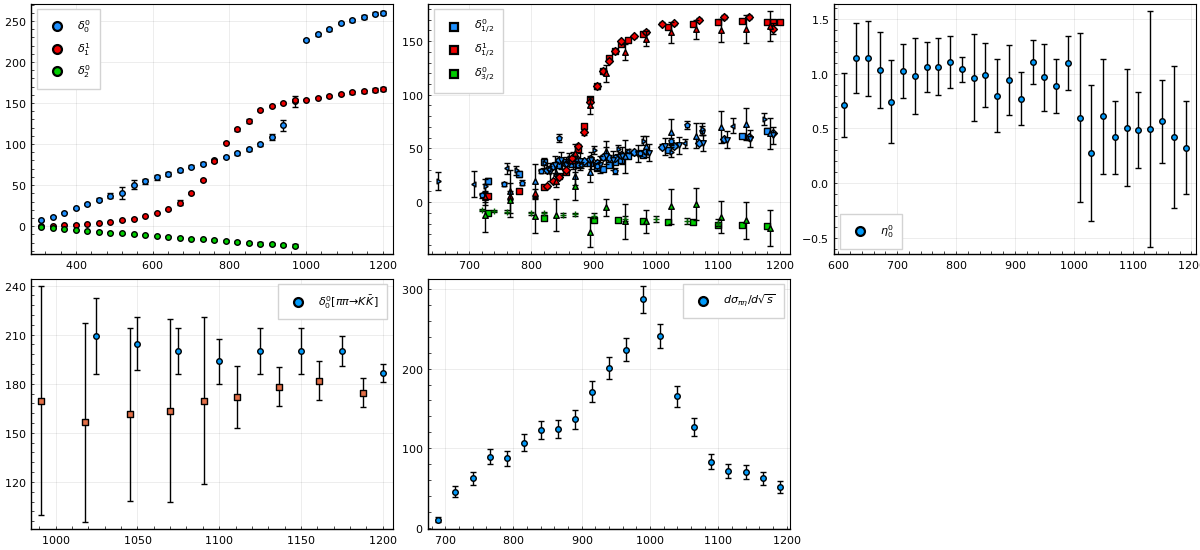

In [58]:
let p1, p2, p3, p4
    p1 = @plt_data data_ππ00 label = L"\delta_{0}^0" marker = (:circle, :dodgerblue)
    @plt_data! data_ππ11 label = L"\delta_{1}^1" marker = (:circle, :red2)
    @plt_data! data_ππ20 label = L"\delta_{2}^0" marker = (:circle, :green3)
    
    p2 = @plt_data Data(data_πK10_Estabrooks_df)[1:19] label = L"\delta_{1/2}^0" marker = (:rect, :dodgerblue)
    @plt_data! Data(data_πK10_Aston_df)[1:21] label = "" marker = (:diamond, :dodgerblue)
    @plt_data! Data(data_πK10_Mercer_df)[1:14] label = "" marker = (:utriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Bingham_df)[1:19] label = "" marker = (:dtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Baker_df) label = "" marker = (:pentagon, :dodgerblue)
    @plt_data! Data(data_πK10_BES_df) label = "" marker = (:rtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_BaBar_df) label = "" marker = (:ltriangle, :dodgerblue)
    
    @plt_data! Data(data_πK11_Estabrooks_df)[1:23] label = L"\delta_{1/2}^1" marker = (:rect, :red2)
    @plt_data! Data(data_πK11_Aston_df)[1:21] label = "" marker = (:diamond, :red2)
    @plt_data! Data(data_πK11_Mercer_df)[1:14] label = "" marker = (:utriangle, :red2)
 
    @plt_data! Data(data_πK30_Estabrooks_df)[1:10] label = L"\delta_{3/2}^0" marker = (:rect, :green3)
    @plt_data! Data(data_πK30_Mercer_df)[1:14] label="" marker = (:utriangle, :green3)
    @plt_data! Data(data_πK30_Lingin_df) label="" marker = (:+, :darkgreen ) #, stroke(:darkgreen))

    p3 = @plt_data data_ππ00_eta label = L"\eta_{0}^0"
    p4 = @plt_data Data(data_ππkk00_Cohen_df) label = L"\delta_{0}^0 [\pi\pi\to K \bar K]"
    @plt_data! Data(data_ππkk00_Martin_df)[1:9] label = "" marker = :rect
    
    p5 = @plt_data data_πη label = L"d\sigma_{\pi\eta}/d\sqrt{s}"
    
    plot(p1, p2, p3, p4, p5, size=(1200,550))
end

# UCHPT

In [10]:
struct TwoBodyChannel{T<:AbstractFloat} 
    m1::T
    m2::T
end

qon(s, m1, m2) = sqrt((s - (m1+m2)^2) * (s - (m1-m2)^2))/(2sqrt(s))

qon (generic function with 1 method)

In [11]:
const ππ = TwoBodyChannel(mpi, mpi)
const KK = TwoBodyChannel(mk, mk)
const ηη = TwoBodyChannel(meta, meta)
const πη = TwoBodyChannel(mpi, meta)
const Kπ = TwoBodyChannel(mk, mpi)
const Kη = TwoBodyChannel(mk, meta);

In [12]:
# load some const definitions used in iam.jl
include("init_const.jl");
# amplitudes from LO and NLO CHPT
include("amplitudes.jl");
# amplitudes from IAM
include("iam.jl");
# modifications to satisfy unitarity
include("unitarity_modification.jl");

In [13]:
const cmatrix22 = zeros(ComplexF64, 2, 2);
const cmatrix33 = zeros(ComplexF64, 3, 3);

In [15]:
# checked with FORTRAN; 0 allocations with julia >=1.5.0
@time St4_11!(cmatrix22, 1040, lecr0) 

  0.000108 seconds


2×2 SArray{Tuple{2,2},Complex{Float64},2,4} with indices SOneTo(2)×SOneTo(2):
 33.9427+7.56418im  6.91715+1.67792im
 6.91715+1.67792im  1.17247+0.372205im

In [16]:
# checked with FORTRAN; 0 allocations with julia >=1.5.0
@btime St4_00!(cmatrix33, 540, lecr0) samples=100

  316.100 μs (0 allocations: 0 bytes)


3×3 SArray{Tuple{3,3},Complex{Float64},2,9} with indices SOneTo(3)×SOneTo(3):
 19.5196+18.817im     5.2616+8.4232im    1.91678-0.366946im
  5.2616+8.4232im    36.0172+3.77055im   -12.335-0.164259im
 1.91678-0.366946im  -12.335-0.164259im  14.1191+0.00715573im

In [17]:
# IJ = 11, ππ, KK; checked with FORTRAN
@btime Stiam_11(540, lecr0) samples=100

  146.900 μs (0 allocations: 0 bytes)


2×2 SArray{Tuple{2,2},Complex{Float64},2,4} with indices SOneTo(2)×SOneTo(2):
  8.63521+1.304im    -1.65164+10.9373im
 -1.65164+10.9373im  -13.8532-2.09197im

In [63]:
# IJ = 00, ππ, KK, ηη; checked with FORTRAN
@time Stiam_00(540, lecr0) #samples=100

  0.000354 seconds


3×3 SArray{Tuple{3,3},Complex{Float64},2,9} with indices SOneTo(3)×SOneTo(3):
  28.1853+37.0394im    16.0719+21.1208im   -0.37278-0.489886im
  16.0719+21.1208im   -13.3513+12.0436im    7.68306-0.279345im
 -0.37278-0.489886im   7.68306-0.279345im   35.0499+0.00647928im

In [16]:
@time Stiam_10(540, lecr0) 

  0.000157 seconds


2×2 SArray{Tuple{2,2},Complex{Float64},2,4} with indices SOneTo(2)×SOneTo(2):
 0.369504+1.73974e-18im  1.27844+5.05334e-18im
  1.27844+5.05334e-18im  4.28488+1.46823e-17im

Linear combinations of LECs:

| NLO amp. | LEC combinations from the NLO scattering amplitudes            |
|:---|:---|
|V4_I0_ππππ, V4_I1_ππππ  | $2L_1 + L_3$, $L_2$, $2L_4+L5$, $2L_6+L_8$ |
|V4_I0_ππkk, V4_I1_kπkπ, V4_I3_kπkπ | $L_1, L_2, L_3, L_4, L_5, 2L_6+L_8$ |
|V4_I0_kkkk, V4_I1_kkkk | $L_1, L_2, L_3, L_4, L_5, 2L_6+L_8$ |
|V4_I0_ππηη, V4_I1_πηπη  | $L_1, L_2, L_3, L_4, 2m_\eta^2 m_\pi^2(-L_5/3 + 2 L_6) + 4m_\pi^2 (- m_\eta^2 + m_\pi^2) L_7 + 2 m_\pi^4 L_8$ |
|V4_I0_kkηη | $L_1, L_2, L_3, L_4, L_5, 8m_\eta^2 m_K^2 (-L_4+L_6) + 2 (3 m_\eta^4 - 4 m_\eta^2 m_\pi^2 + m_\pi^4) L_7 + (6 m_\eta^4 - 3 m_\eta^2 m_\pi^2 + m_\pi^4) L_8$ |
|V4_I1_πηkk | $L_3, L_5, 6(m_\eta^4-m_\pi^4)(2L_7+ L_8)$|

In [25]:
function cont(v4, i, j; c = 2, pw = swave)
    n = 100
    x = LinRange(-3e-3,3e-3,n)
    y = LinRange(-3e-3,3e-3,n)
    f(s, x, y) = begin
        _lec = lecr0;
        _lec[i] = x; _lec[j] = y;
        real(pw(z -> v4(s, z, _lec)))
    end
    f1(x, y) = f(450^2, x, y)
    f2(x, y) = f(850^2, x, y)
    X = repeat(reshape(x, 1, :), length(y), 1)
    Y = repeat(y, 1, length(x))
    Z1 = map(f1, X, Y); c1 = contour(X, Y, Z1); 
    plot!(x, (@. -c*x), line = :dash, ylim = (y[1],y[end]), label = "$c L($i)+L($j)")
    Z2 = map(f2, X, Y); c2 = contour(X, Y, Z2); 
    plot!(x, (@. -c*x), line = :dash, ylim = (y[1],y[end]), label = "$c L($i)+L($j)")
#     f1(x, y) = real(pwave(z -> V4_I0_ππkk(s, z, [lecr0[1],x,y,lecr0[4:end]...]))); Z1 = map(f1, X, Y)
#     c2 = contour(X, Y, Z1)
    plot(c1, c2, size = (800,330), xlab = "L($i)", ylab = "L($j)")
end

cont (generic function with 1 method)

  3.519597 seconds (5.24 M allocations: 259.149 MiB, 3.44% gc time)


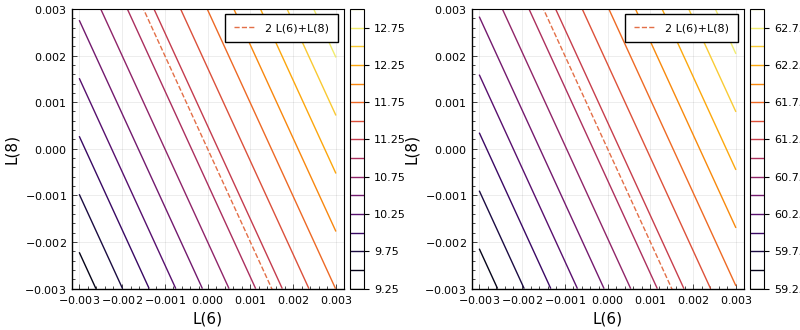

In [28]:
pyplot()
@time cont(V4_I0_ππππ , 6, 8; c = 2, pw = swave)

In [179]:
function δ00_0(w, lec) # without considering continuity
    _m1, _m2 = ππ.m1, ππ.m2
    if w ≥ _m1 + _m2
        _q = qon(w^2, _m1, _m2)
        _tm = Stiam_00(w, lec)[1, 1]
        res = 0.5atand(real(_tm), -imag(_tm) + 4π*w/_q )
    else
        res = 0.0
    end
    return  res
end

# for easy plot
function δ00(w, lec; jump = 900, jumpd = 80) 
    res = δ00_0(w, lec)
    return  (w>jump && res <jumpd) ? res + 180 : res
end

function η00(w, lec)
    _m1 = _m2 = ππ.m1;  _m3 = _m4 = KK.m1
    if w ≥ _m3 + _m4
        _s = w^2
        _q1 = qon(_s, _m1, _m2)
        _q2 = qon(_s, _m3, _m4)
        _tm = abs2(Stiam_00(w, lec)[2, 1])
        res = sqrt( 1 - _q1 * _q2/(16π^2*_s) * _tm )
    else
        res = 1.0
    end
    return  res
end

function δππkk00(w, lec) 
    if w < KK.m1 + KK.m2
        res = δ00(w, lec)
    else
        _tm = Stiam_00(w, lec)[1, 2]
        res = atand(imag(_tm), real(_tm))
    end
    return res < 0 ? res + 360 : res
end

function δ11_0(w, lec)
    _m1, _m2 = ππ.m1, ππ.m2
    if w ≥ _m1 + _m2
        _q = qon(w^2, _m1, _m2)
        _tm = Stiam_11(w, lec)[1, 1]
        res = 0.5atand(real(_tm), -imag(_tm) + 4π*w/_q )
    else
        res = 0.0
    end
    return  res
end
function δ11(w, lec) 
    res = δ11_0(w, lec)
    return res < 0 ? res + 180 : res
end

function δ20(w, lec)
    _m1, _m2 = ππ.m1, ππ.m2
    if w ≥ _m1 + _m2
        _q = qon(w^2, _m1, _m2)
        _tm = tiam_20(w, lec)
        res = 0.5atand(real(_tm), -imag(_tm) + 4π*w/_q )
    else
        res = 0.0
    end
    return  res 
end

function δhalf0_0(w, lec)
    _m1, _m2 = Kπ.m1, Kπ.m2
    if w ≥ _m1 + _m2
        _q = qon(w^2, _m1, _m2)
        _tm = Stiam_strange_10(w, lec)[1, 1]
        res = 0.5atand(real(_tm), -imag(_tm) + 4π*w/_q )
    else
        res = 0.0
    end
    return  res 
end
function δhalf0(w, lec) 
    res = δhalf0_0(w, lec)
    return res < 0 ? res + 180 : res
end

function δhalf1_0(w, lec)
    _m1, _m2 = Kπ.m1, Kπ.m2
    if w ≥ _m1 + _m2
        _q = qon(w^2, _m1, _m2)
        _tm = Stiam_strange_11(w, lec)[1, 1]
        res = 0.5atand(real(_tm), -imag(_tm) + 4π*w/_q )
    else
        res = 0.0
    end
    return  res 
end
function δhalf1(w, lec) 
    res = δhalf1_0(w, lec)
    return res < 0 ? res + 180 : res
end

function δ3half0(w, lec)
    _m1, _m2 = Kπ.m1, Kπ.m2
    if w ≥ _m1 + _m2
        _q = qon(w^2, _m1, _m2)
        _tm = tiam_strange_30(w, lec)
        res = 0.5atand(real(_tm), -imag(_tm) + 4π*w/_q )
    else
        res = 0.0
    end
    return  res 
end

# πη invariant mass distribution
function σπη(w, paras)
    _m1, _m2 = πη.m1, πη.m2
    _c = @views paras[9]
    if w ≥ _m1 + _m2 + 0.0000001
        _q = qon(w^2, _m1, _m2)
        _tm = Stiam_10(w, @views paras[1:8])[2, 1]
        res = _c * _q * abs2(_tm ) + data_πη_WA76_bg(w) # _bg* _q^4 )
    else
        res = 0.0
    end
    return  res 
end

σπη (generic function with 1 method)

In [119]:
@time σπη(980, paras0) 

  0.000254 seconds


164.30315692649876

In [306]:
function plt_compare(paras; jump = 900)
    _lec = Ref(paras[1:8])
    wv = 270:1.0:1200
    p1 = plot(wv, δ00.(wv, _lec; jump = jump), label="", xlim = (wv[1], wv[end]))
    plot!(wv, δ11.(wv, _lec), label="" )
    plot!(wv, δ20.(wv, _lec), label="" )
    @plt_data! data_ππ00 label = L"\delta_{0}^0" marker = (:circle, :dodgerblue)
    @plt_data! data_ππ11 label = L"\delta_{1}^1" marker = (:circle, :darkorange)
    @plt_data! data_ππ20 label = L"\delta_{2}^0" marker = (:circle, :green3) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (\pi\pi\to \pi\pi)"
    hline!([0], color = :black, label=:none)    
    
    xv = 630:1.0:1200
    p2 = plot(xv, δhalf0.(xv, _lec), label="", xlim = (xv[1], xv[end]))
    plot!(xv, δhalf1.(xv, _lec), label="" )
    plot!(xv, δ3half0.(xv, _lec), label="" )
    @plt_data! Data(data_πK10_Estabrooks_df)[1:19] label = L"\delta_{1/2}^0" marker = (:rect, :dodgerblue)
    @plt_data! Data(data_πK10_Aston_df)[1:21] label = "" marker = (:diamond, :dodgerblue)
    @plt_data! Data(data_πK10_Mercer_df)[1:14] label = "" marker = (:utriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Bingham_df)[1:19] label = "" marker = (:dtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Baker_df) label = "" marker = (:pentagon, :dodgerblue)
    @plt_data! Data(data_πK10_BES_df) label = "" marker = (:rtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_BaBar_df) label = "" marker = (:ltriangle, :dodgerblue)
    
    @plt_data! Data(data_πK11_Estabrooks_df)[1:23] label = L"\delta_{1/2}^1" marker = (:rect, :darkorange)
    @plt_data! Data(data_πK11_Aston_df)[1:21] label = "" marker = (:diamond, :darkorange)
    @plt_data! Data(data_πK11_Mercer_df)[1:14] label = "" marker = (:utriangle, :darkorange)
 
    @plt_data! Data(data_πK30_Estabrooks_df)[1:10] label = L"\delta_{3/2}^0" marker = (:rect, :green3)
    @plt_data! Data(data_πK30_Mercer_df)[1:14] label="" marker = (:utriangle, :green3)
    @plt_data! Data(data_πK30_Lingin_df) label="" marker=(:circle, :darkgreen) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (K\pi\to K \pi)"
    hline!([0], color = :black, label=:none)   
    
    wv2 = 985:1.0:1200
    p3 = plot(wv2, δππkk00.(wv2, _lec), label = "", xlim = (wv2[1], wv2[end]), ylim=(0,260) )
    @plt_data! Data(data_ππkk00_Cohen_df) label = "" marker = :darkorange
    @plt_data! Data(data_ππkk00_Martin_df)[1:9] label="" marker=(:rect,:darkorange) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{0}^0 (\pi\pi\to K \bar K)"
       
    p4 = plot(wv2, η00.(wv2, _lec), legend = :none, xlim = (wv2[1], wv2[end]), ylim=(0, 1.6))
    @plt_data! data_ππ00_eta marker = :darkorange xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\eta_{0}^0" # label = L"\eta_{0}^0"
    
    wv3 = (mpi+meta+0.000001):1.0:1075
    p5 = plot(wv3, σπη.(wv3, Ref(paras)), label = "", xlim = (wv3[1], wv3[end]) )
    @plt_data! data_πη[1:16] label = "" 
    plot!(wv3, data_πη_WA76_bg.(wv3), line=(:dashdot, :gray), label="background" )
    plot!(xlab=L"\sqrt{s}"*" [MeV]", ylab = L"d\sigma_{\pi\eta}/d\sqrt{s}"*" [events/25 MeV]", ylim=(0, 320))
    
    plot(p1, p2, p3, p4, p5, size=(1200,550))
end

plt_compare (generic function with 1 method)

  2.696919 seconds (5.53 M allocations: 292.162 MiB, 4.99% gc time)


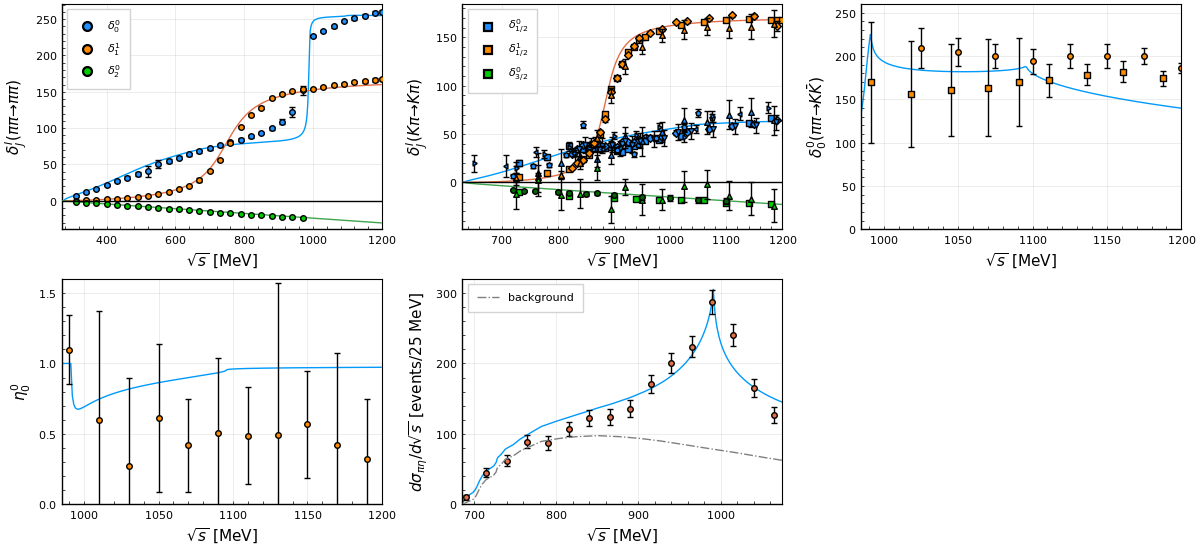

In [307]:
@time plt_compare([lecr0..., 1e-4]; jump = 900)

In [187]:
function plt_unitarity_test(tm, ch1, ch2; lec=lecr0, kwds...) 
#     ch1 = ππ; ch2 = KK;
    wv = (ch1.m1+ch1.m2):1:1100 #(ch2.m1+ch2.m2)
    tij(w) = tm(w, lec)  
    _im1(w) = imag(tij(w)[1,1])
    _re1(w) = real(tij(w)[1,1])
    _abs2(w) = abs2(tij(w)[1,1])
    _rho1(w) = qon(w^2, ch1.m1, ch1.m2)/(8π*w); _rho2(w) = qon(w^2, ch2.m1, ch2.m2)/(8π*w)
    _rhs(w) = (w <= ch2.m1+ch2.m2 ? _abs2(w) * _rho1(w) : 
        _abs2(w) * _rho1(w) + abs2(tij(w)[1,2])*_rho2(w))
    p1 = plot(wv, _im1.(wv); label = "Im "*L"T", kwds... )
    plot!(wv, _rhs.(wv); label = L"T\Sigma T^\dag", line = :dash )
    plot!(wv, _re1.(wv); label = "Re "*L"T", line = :dot )
end

plotly()
function plt_unitarity(lec)
    p1 = plt_unitarity_test(Stiam_00, ππ, KK, lec=lec, ylab = L"T_0^0[\pi\pi\to \pi\pi]")
    p2 = plt_unitarity_test(Stiam_11, ππ, KK, lec=lec, xlab = L"\sqrt{s}"*" [MeV]", ylab = L"T_1^1[\pi\pi\to \pi\pi]")
    p3 = plt_unitarity_test(Stiam_10, πη, KK, lec=lec, xlab = L"\sqrt{s}"*" [MeV]", ylab = L"T_1^0[\pi\eta\to \pi\eta]")
    p4 = plt_unitarity_test(Stiam_strange_10, Kπ, Kη, lec=lec, ylab = L"T_0^{1/2}[K\pi\to K\pi]")
    p5 = plt_unitarity_test(Stiam_strange_11, Kπ, Kη, lec=lec, xlab = L"\sqrt{s}"*" [MeV]", ylab = L"T_1^{1/2}[K\pi\to K\pi]")
    plot(p1, p2, p3, p4, p5, layout = 5, size=(1200,500))
end

plt_unitarity (generic function with 1 method)

In [16]:
function plt_iam(lec; amp=:nlo)
    wv = 200:1:1200
#     stm00(w) = Stiam_00(w, lec)[1,1]
    n = 9
    p = Vector{Any}(undef, n)
    for i = 1:n
    stm11(w) = amp==:nlo ? St4_00!(cmatrix33, w, lec)[i] : Stiam_00(w, lec)[i] #St2_00!(cmatrix33, w)[i] - 
    p[i] = plot( wv, (@. real(stm11(wv)) ), label="Re T($i)" )
    plot!( wv, (@. imag(stm11(wv)) ), line = :dash, label="Im T($i)" )
    end
    plot(p..., layout = n) #, legend=:outertopright)
end

plt_iam (generic function with 1 method)

In [26]:
include("iam.jl")

tiam_strange_30 (generic function with 1 method)

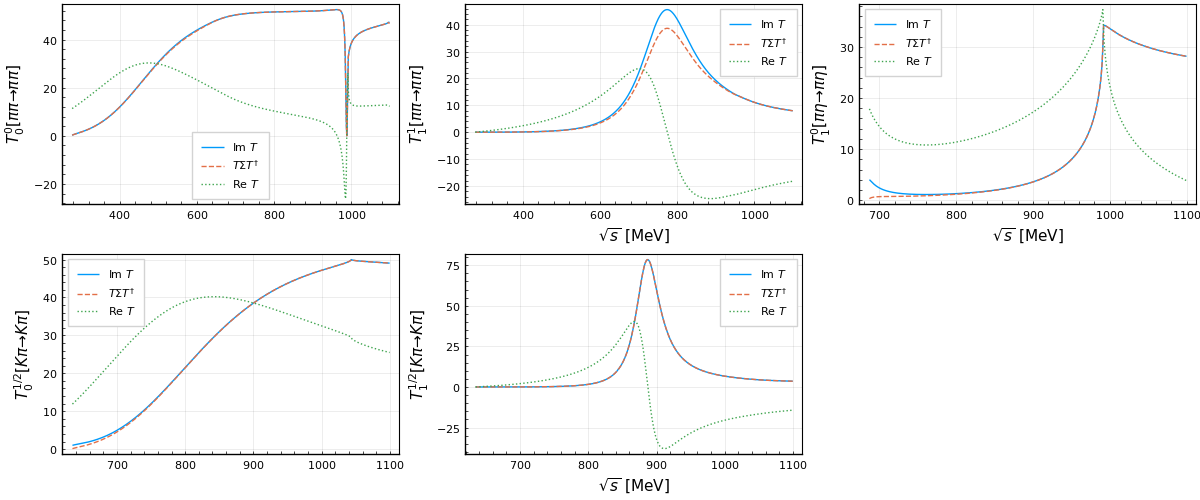

In [27]:
pyplot()
plt_unitarity(lecr0)
# savefig("unitarity_nomod.pdf")

In [28]:
include("unitarity_modification.jl")

St4_strange_11! (generic function with 1 method)

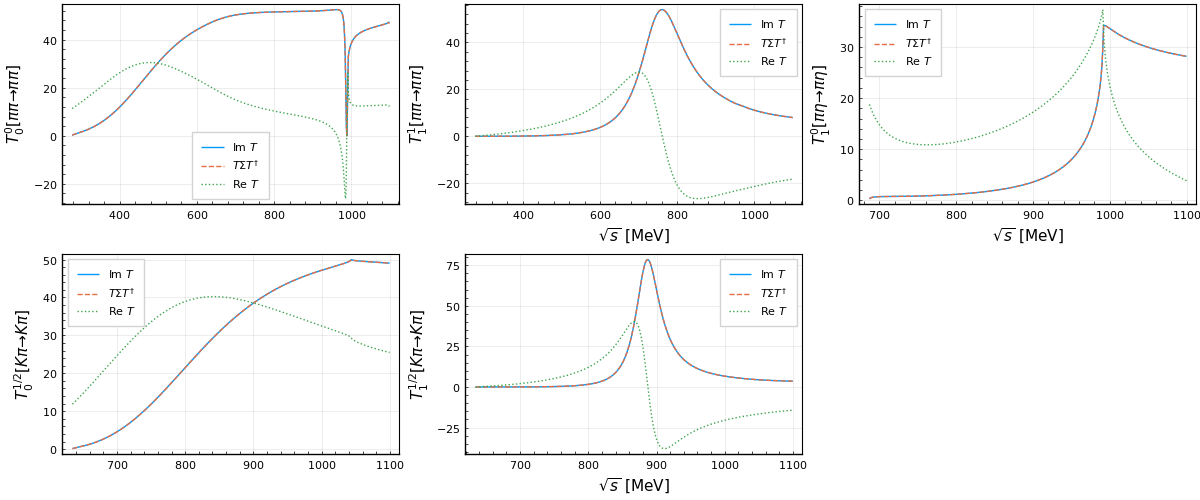

In [30]:
plt_unitarity(lecr0)
# savefig("unitarity_mod.pdf")

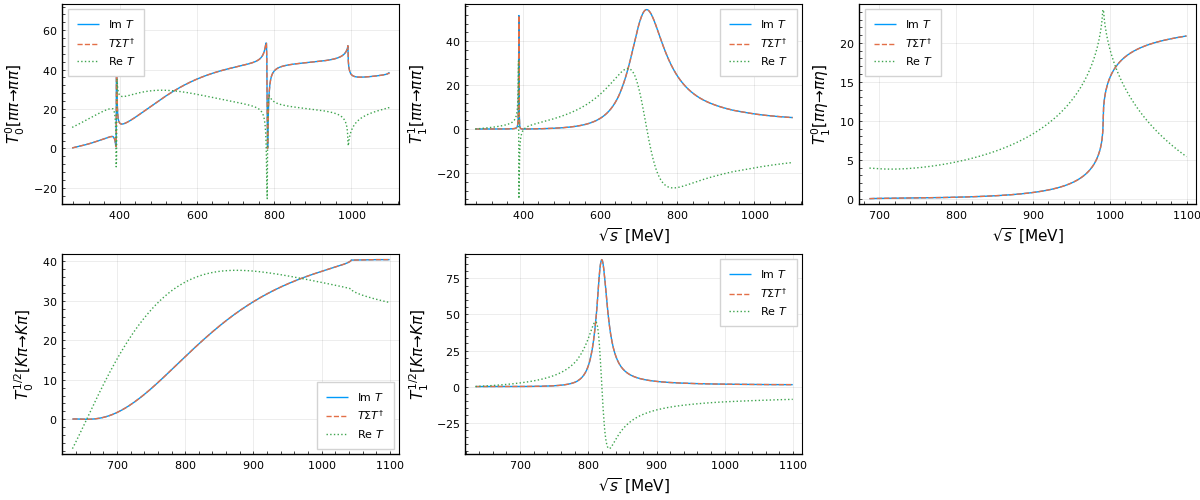

In [31]:
pyplot()
plt_unitarity(lec_chpt)

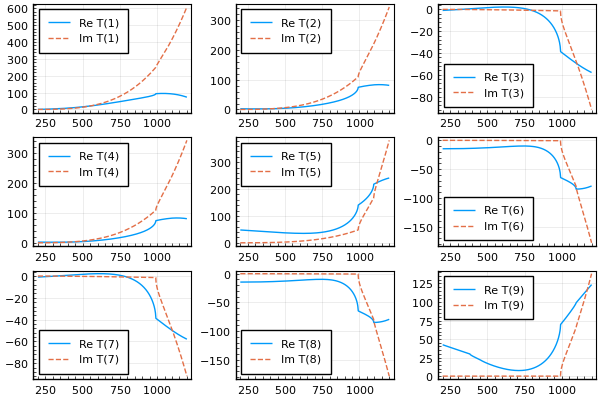

In [82]:
plt_iam(lecr0)

# Fits

Following [Kaminski et al.m Phys.Lett.B 551 (2003) 241-248](https://inspirehep.net/literature/600560), the chi-square for fitting to the phase shifts can be defined as
\begin{equation}
  \chi^2 = \sum_{i = 1}^N \left[ \frac{\sin\left(\delta_\ell^I(s_i) - \varphi_\ell^I(s_i) \right) }{\Delta\varphi_\ell^I(s_i)} \right]^2,
\end{equation}
where $\varphi_\ell^I(s_i)$ and $\Delta\varphi_\ell^I(s_i)$ are the phase shift data and the errors.
This should be understood as the phases are expressed in units of radians.

In [188]:
# as defined above
function chisq_ps(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) ? (1:data.ndata) : fitrange)
    res = 0.0
    @simd for i = fitrange[1]:fitrange[end]
        @inbounds res += ( sind(data.y[i]- dist(data.x[i], par))/(data.err[i]*π/180) )^2
    end
    return res
end

# to ensure continuity of phase shifts in resonant partial waves; unneessary in the case of using sin
function chisq_continuity(dist::Function, data::Data, par; fitrange = ())
    fitrange = (isempty(fitrange) && 1:data.ndata)
    res = 0.0
     _ps0 = 0.0; _jump = -20.0
    @simd for i = fitrange
        _ps = dist(data.x[i], par)
        if _ps - _ps0 < _jump  
            _ps += 180.0
        end
        _ps0 = _ps
        @inbounds res += ( sind(data.y[i] - _ps)/(data.err[i]*π/180) )^2
    end
    return res
end

# here define chisq to let 2L6+L8 be treated a linear combination
for str in ["chisq", "chisq_continuity", "chisq_ps"]
    _chsq68 = Symbol("$(str)_68")
    _chsq = Symbol("$(str)")
    _expr = quote
        function ($_chsq68)(f, data, pars) 
            _pars = zeros(length(pars))
            for i = 1:7 
                @views _pars[i] = pars[i]
            end
            @views _pars[8] = pars[8] - 2pars[6]
            return ($_chsq)(f, data, _pars)
        end
    end
    eval(_expr)
end


In [33]:
const lec_for_best = (0.3461, 0.9102, -2.6452, -0.5261, 1.03, 0.07, -0.62, 1.11) .*1e-3;

In [203]:
name = [:L1, :L2, :L3, :L4, :L5, :L6, :L7, :L8, :c];

In [35]:
@time chisq_continuity(δhalf0, data_πK10, lecr0), chisq_ps(δhalf0, data_πK10, lecr0)

  0.041342 seconds


(744.8421818066439, 744.8421818066439)

In [36]:
function plt_paras(df::DataFrame, col1, col2)
    scatter(df[!, col1], df[!, col2], xlab = col1, ylab=col2, label = :none)
end

# show scatter plots of all parameter combinations
function plt_paras(df::DataFrame)
    paras = (:L1, :L2, :L3, :L4, :L5, :L7, :L8)
    plt = Array{Any, 2}(undef, 7,7)
    for i in eachindex(paras)
        for j in eachindex(paras) 
            plt[i,j] = plt_paras(df, paras[i], paras[j])
        end
    end
    plot(plt..., size = (1350, 900))
end

plt_paras (generic function with 2 methods)

In [37]:
# for plotting error bands
function dist_minmax(df::DataFrame, fitfun, w)
        m = size(df)[1]
        _tempvec = zeros(m)
        @inbounds @simd for i = 1:m      
            _tempvec[i] = fitfun(w, Array(df[i, 2:end]))
        end
        return [extrema(_tempvec)...]
end

function plt_band(df::DataFrame, ch::TwoBodyChannel, fitfun; color= :gray, kws...) 
    dist_extrema(w) = dist_minmax(df, fitfun, w)  
    n = 100; 
    wv = LinRange(ch.m1+ch.m2, 1200, n)
    paras = Array(df[1, 2:end])
    _yv = permutedims(reduce(hcat, dist_extrema.(wv)))  
    plot( wv, [_yv[:,1]]; color= color, fill = ([_yv[:,2]], color), fillalpha = 0.5, label="", kws... )
end
function plt_band!(df::DataFrame, ch::TwoBodyChannel, fitfun; color= :gray, kws...)
    dist_extrema(w) = dist_minmax(df, fitfun, w)  
    n = 100; 
    wv = LinRange(ch.m1+ch.m2, 1200, n)
    best = zeros(Float64, n); 
    paras = Array(df[1, 2:end])
    _yv = permutedims(reduce(hcat, dist_extrema.(wv)))  
    plot!( wv, _yv[:,1]; color= color, label="", fill = (_yv[:,2], color), fillalpha = 0.5, kws...)
end

plt_band! (generic function with 1 method)

In [23]:
pyplot();

## using the errors from the data

In [241]:
χsq_00(pars) = chisq_ps(δ00_0, data_ππ00, @views pars[1:8] )
χsq_11(pars) = chisq_ps(δ11, data_ππ11, @views pars[1:8] ) 
χsq_20(pars) = chisq_ps(δ20, data_ππ20, @views pars[1:8] )
χsq_half0(pars) = chisq_ps(δhalf0, data_πK10, @views pars[1:8])
χsq_half1(pars) = chisq_ps(δhalf1, data_πK11, @views pars[1:8])
χsq_3half0(pars) = chisq_ps(δ3half0, data_πK30, @views pars[1:8])
χsq_η00(pars) = chisq(η00, data_ππ00_eta, @views pars[1:8] )
# for this one, needs to check whether the minimum is such that the phase is too small by 180 degrees
χsq_ππkk00(pars) = chisq_ps(δππkk00, data_ππKK00, @views pars[1:8] );

χsq_πη(pars) = chisq(σπη, data_πη[1:16], pars );

In [222]:
@time χsq_πη(paras0)

  0.002272 seconds (3 allocations: 624 bytes)


34.03098897390135

In [197]:
data_ππ00.ndata, data_ππ11.ndata, data_ππ20.ndata, data_πK10.ndata, data_πK11.ndata, data_πK30.ndata,
data_ππKK00.ndata, data_ππ00_eta.ndata, data_πη.ndata

(31, 31, 23, 103, 58, 36, 17, 30, 21)

In [242]:
macro show_individual(lec)
    summing = 0.0
    _list = ["00", "11", "20", "half0", "half1", "3half0", "ππkk00", "η00", "πη"]
    dofs = (31, 31, 23, 103, 58, 36, 17, 30, 16)
    for i in eachindex(_list)
        func = Symbol("χsq_$(_list[i])")
        res = :(($func)($lec))
        @eval println("χ^2/dof in ", $(_list[i]), ":  ", $res/($(dofs[i])-8) )
        summing += eval(res)
    end
    @eval println("Total χ^2/dof:   ", $summing/(sum($dofs) -8) )
end

@show_individual (macro with 1 method)

In [243]:
χsq(pars) = (χsq_00(pars)  + χsq_11(pars) + χsq_20(pars) + χsq_ππkk00(pars) + χsq_η00(pars)
             + χsq_half0(pars) + χsq_half1(pars) + χsq_3half0(pars) + χsq_πη(pars) 
    )
fit0 = Minuit(χsq, paras0, error=1e-6*ones(9), name = name,
     fix_L1=false, fix_L3=false, fix_L4=false, fix_L5=false, fix_L6=true, fix_L7=false, fix_L8=false
)
fit0.strategy = 2;

In [244]:
@show_individual  paras0

χ^2/dof in 00:  32.647183679852944
χ^2/dof in 11:  21.02917970628029
χ^2/dof in 20:  2.2726356060619546
χ^2/dof in half0:  7.840444019017304
χ^2/dof in half1:  44.08113810950782
χ^2/dof in 3half0:  9.83629972334994
χ^2/dof in ππkk00:  14.045825516692693
χ^2/dof in η00:  0.648408701580309
χ^2/dof in πη:  4.773238134776266
Total χ^2/dof:   13.862981298727115


In [245]:
@time migrad(fit0)

 21.785693 seconds (40.19 k allocations: 1.935 MiB, 0.29% gc time)


PyObject MigradResult(fmin=FMin(fval=2615.6123682248417, edm=5.060536969650601e-06, tolerance=0.1, nfcn=350, ncalls=350, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='L1', value=0.0005237280029954493, error=5.728906493493489e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.0010768679950392953, error=9.197024458245969e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.002719569592300984, error=9.020471075285418e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.00026495366804720936, error=7.320075641123057e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.0013792773274929554, error=0.00018016699648740788, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0006093963451238767, error=3.315399122073298e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.0009051562498835476, error=8.517749026962366e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010253615438484852, error=5.150782936236251e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [246]:
@show_individual  args(fit0)

χ^2/dof in 00:  31.02943806342814
χ^2/dof in 11:  17.133555282529368
χ^2/dof in 20:  0.49656791777094766
χ^2/dof in half0:  4.970287466592625
χ^2/dof in half1:  11.890543780031466
χ^2/dof in 3half0:  7.964131783618032
χ^2/dof in ππkk00:  16.256366728788766
χ^2/dof in η00:  0.6044457204336446
χ^2/dof in πη:  6.388713477929732
Total χ^2/dof:   7.7614610333081355


In [230]:
@time hesse(fit0)
@time hesse(fit0)

  3.717668 seconds (9.51 k allocations: 499.870 KiB)
  3.666631 seconds (3.85 k allocations: 212.812 KiB)


PyObject [Param(number=0, name='L1', value=0.000523464235831207, error=6.116586291922161e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.001076274837212056, error=9.548277940513777e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.002720279032713509, error=9.646754512021577e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.0002646793347537954, error=7.450063804268498e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.001357493467307229, error=0.0001905587466482066, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0006002444369394895, error=3.565007560197615e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.0008918311308852359, error=9.086588741139038e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010690185645072089, error=5.645233963825748e-06, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)]

In [248]:
@time minos(fit0)

 96.697829 seconds (98.42 k allocations: 5.315 MiB)


PyObject MErrors([('L1', MError(name='L1', is_valid=True, lower=-6.131981928639708e-06, upper=6.111773761574199e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=198, min=0.0005237280029954493)), ('L2', MError(name='L2', is_valid=True, lower=-9.529070706279107e-06, upper=9.566068512133608e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=202, min=0.0010768679950392953)), ('L3', MError(name='L3', is_valid=True, lower=-9.688148454436228e-06, upper=9.615782699629947e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=187, min=-0.002719569592300984)), ('L4', MError(name='L4', is_valid=True, lower=-7.557523162736482e-06, upper=7.357515438795724e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=184, min=-0.00026495366804720936)), ('L5', MError(name='L5', is_valid=True, lower=-0.0001913049768262817, upper=0.00019028116902569306, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=200, min=0.0013792773274929554)), ('L7', MError(name='L7', is_valid=True, lower=-3.447934045428113e-05, upper=3.555281566897903e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=263, min=-0.0006093963451238767)), ('L8', MError(name='L8', is_valid=True, lower=-9.09667651098897e-05, upper=9.028401337517799e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=189, min=0.0009051562498835476)), ('c', MError(name='c', is_valid=True, lower=-5.125772500589428e-06, upper=5.206059809445836e-06, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=139, min=0.00010253615438484852))])

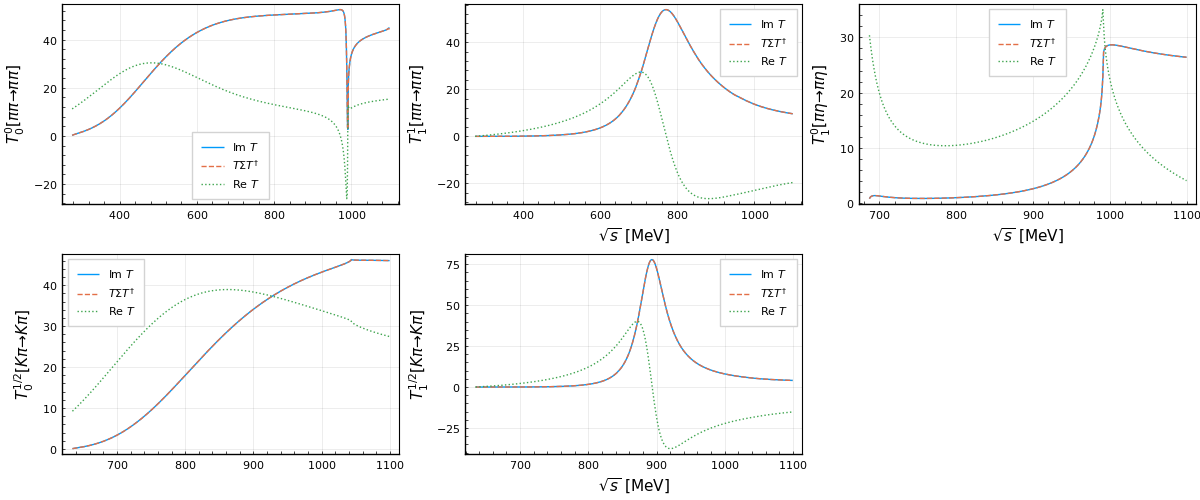

In [247]:
pyplot()
plt_unitarity(args(fit0) )

  0.960418 seconds (138.65 k allocations: 7.553 MiB)


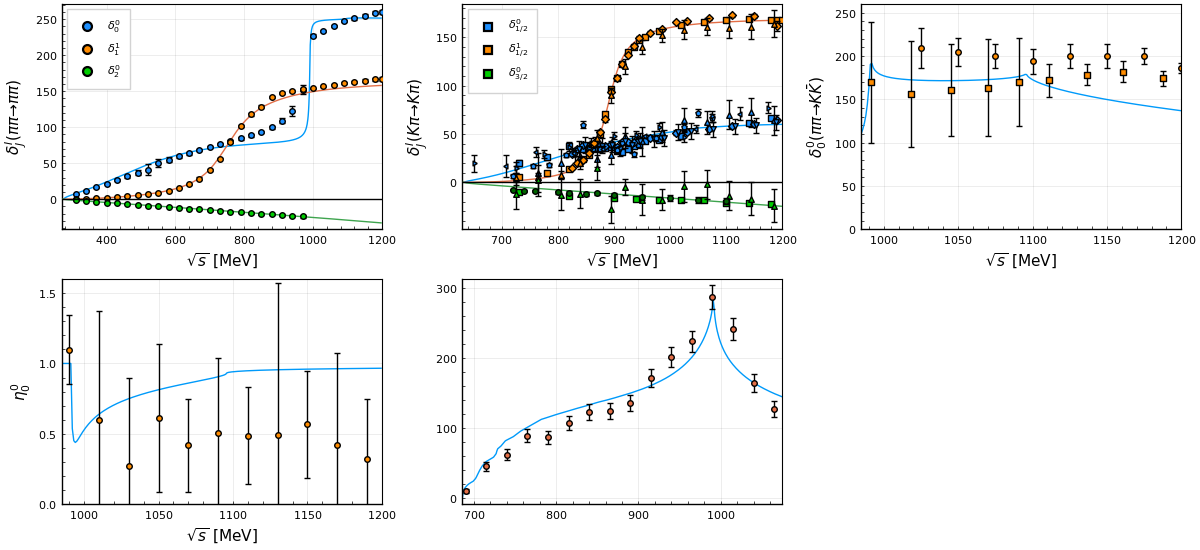

In [249]:
# pyplot()
@time plt_compare(args(fit0), jump = 950)

### with increased errors following the paper by Gomez Nicola and Pelaez

In [250]:
const add_err = 0.05; 
const lec_best0 = [0.522, 1.081, -2.7, -0.279, 1.87, 0.07, -1.29, 1.70] .*1e-3;

In [251]:
# increase the data error by  `factor` times of the data value
# weight(dat::Data, factor) = Data(dat.x, dat.y, dat.err .* factor)
weight(dat::Data, factor) = Data(dat.x, dat.y, (@. dat.err + factor * abs(dat.y)) );

In [252]:
χsq_pc_00(pars) = chisq_ps(δ00_0, weight(data_ππ00, add_err), @views pars[1:8])
χsq_pc_11(pars) = chisq_ps(δ11, weight(data_ππ11, add_err), @views pars[1:8]) 
χsq_pc_20(pars) = chisq_ps(δ20, weight(data_ππ20, add_err), @views pars[1:8])
χsq_pc_η00(pars) = chisq(η00, weight(data_ππ00_eta, add_err), @views pars[1:8]);
χsq_pc_ππkk00(pars) = chisq_ps(δππkk00, weight(data_ππKK00, add_err), @views pars[1:8])

χsq_pc_half0(pars) = chisq_ps(δhalf0, weight(data_πK10, add_err), @views pars[1:8])
χsq_pc_half1(pars) = chisq_ps(δhalf1, weight(data_πK11, add_err), @views pars[1:8])
χsq_pc_3half0(pars) = chisq_ps(δ3half0, weight(data_πK30, add_err), @views pars[1:8]);

χsq_pc_πη(pars) = chisq(σπη, weight(data_πη[1:16], add_err), pars);

In [253]:
macro show_individual_pc(lec)
    summing = 0.0
    _list = ["00", "11", "20", "half0", "half1", "3half0", "ππkk00", "η00", "πη"]
    dofs = (31, 31, 23, 103, 58, 36, 17, 30, 16)
    for i in eachindex(_list)
        func = Symbol("χsq_pc_$(_list[i])")
        res = :(($func)($lec))
        @eval println("χ^2/dof in ", $(_list[i]), ":  ", $res/($(dofs[i])-8) )
        summing += eval(res)
    end
    @eval println("Total χ^2/dof:   ", $summing/(sum($dofs) -8) )
end

@show_individual_pc (macro with 1 method)

In [255]:
@show_individual_pc paras0

χ^2/dof in 00:  2.753083511582777
χ^2/dof in 11:  0.8386024487773054
χ^2/dof in 20:  0.5014422861004179
χ^2/dof in half0:  2.4038224841020175
χ^2/dof in half1:  2.2254798584613233
χ^2/dof in 3half0:  3.0104110556693113
χ^2/dof in ππkk00:  3.0816832600048674
χ^2/dof in η00:  0.5543094075790158
χ^2/dof in πη:  1.9681515893769514
Total χ^2/dof:   1.690605990721319


In [256]:
@show_individual_pc args(fit0)

χ^2/dof in 00:  3.0040345931124346
χ^2/dof in 11:  0.43511956629392634
χ^2/dof in 20:  0.10036921132070496
χ^2/dof in half0:  1.5532271475380024
χ^2/dof in half1:  1.2111065605387552
χ^2/dof in 3half0:  2.5099683682761826
χ^2/dof in ππkk00:  3.6530183023024048
χ^2/dof in η00:  0.5145522679410838
χ^2/dof in πη:  2.7670879534019943
Total χ^2/dof:   1.2621101585566155


In [257]:
χsq_pc(pars) = (χsq_pc_00(pars)  + χsq_pc_11(pars) + χsq_pc_20(pars) + χsq_pc_ππkk00(pars) + χsq_pc_η00(pars)
             + χsq_pc_half0(pars) + χsq_pc_half1(pars) + χsq_pc_3half0(pars) + χsq_pc_πη(pars)
    )
fit_pc = Minuit(χsq_pc, paras0, error=1e-6*ones(9), name = name,
     fix_L1=false, fix_L3=false, fix_L4=false, fix_L5=false, fix_L6=true, fix_L7=false, fix_L8=false
)
fit_pc.strategy = 2;

In [258]:
@time migrad(fit_pc)

 28.846273 seconds (54.20 k allocations: 4.153 MiB)


PyObject MigradResult(fmin=FMin(fval=406.4281124287577, edm=3.1548146220721034e-05, tolerance=0.1, nfcn=495, ncalls=495, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='L1', value=0.000545992125171509, error=1.679433960097317e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.001070170404082816, error=2.9532909258708796e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.0027564909145106446, error=3.237134349549853e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.0002015527954327719, error=1.7900626987279286e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.0011282705446630317, error=0.0005853591051928495, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0005246808600062155, error=0.0001116548898793572, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.000680646936499464, error=0.0002747869591084547, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010919586111455271, error=1.0495787402017307e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [259]:
lec_best_plus5pc = [0.546, 1.07, -2.756, -0.202, 1.1, 0.07, -0.52, 0.68, 0.109] .*1e-3;

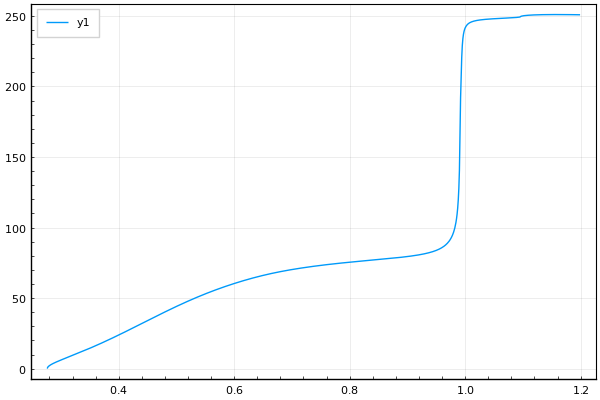

In [260]:
pyplot()
let wv = 0.27608:0.001:1.2
    plot(wv, x->δ00(1000x, @views lec_best_plus5pc[1:8]; jump=920) )
end

In [261]:
let wv = 0.002mpi:0.001:1.20008, ps00, df
    ps00 = δ00.(1000 .*wv, Ref(lec_best_plus5pc[1:8]); jump=920)
    df = DataFrame([wv, ps00], [:mpipi, :delta00])
    CSV.write("ps00IAM_coupledchannel.csv", df)
end

"ps00IAM_coupledchannel.csv"

In [262]:
@show_individual_pc args(fit_pc)

χ^2/dof in 00:  2.940189358777993
χ^2/dof in 11:  0.702515898601275
χ^2/dof in 20:  0.09915081765004258
χ^2/dof in half0:  1.4441213422880965
χ^2/dof in half1:  1.0665417417664471
χ^2/dof in 3half0:  2.4458710763474163
χ^2/dof in ππkk00:  3.640445129135695
χ^2/dof in η00:  0.47740128674792287
χ^2/dof in πη:  2.3610987537736436
Total χ^2/dof:   1.2060181377707944


In [263]:
@time hesse(fit_pc)
@time hesse(fit_pc)

  3.674780 seconds (4.40 k allocations: 429.172 KiB)
  3.424608 seconds (4.40 k allocations: 429.172 KiB)


PyObject [Param(number=0, name='L1', value=0.000545992125171509, error=1.8048618093132815e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.001070170404082816, error=3.018849759331694e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.0027564909145106446, error=3.438413062419838e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.0002015527954327719, error=1.796944429571339e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.0011282705446630317, error=0.0006085929529077723, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0005246808600062155, error=0.00011577287411495985, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.000680646936499464, error=0.00028615253190638343, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010919586111455271, error=1.0517793192279298e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)]

In [264]:
@time minos(fit_pc)

104.129660 seconds (129.97 k allocations: 12.394 MiB)


PyObject MErrors([('L1', MError(name='L1', is_valid=True, lower=-1.8185456757436333e-05, upper=1.8041023624667627e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=146, min=0.000545992125171509)), ('L2', MError(name='L2', is_valid=True, lower=-2.9913432973770335e-05, upper=3.056658642498677e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=173, min=0.001070170404082816)), ('L3', MError(name='L3', is_valid=True, lower=-3.4789810972731435e-05, upper=3.420200409220762e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=172, min=-0.0027564909145106446)), ('L4', MError(name='L4', is_valid=True, lower=-2.0100513544218395e-05, upper=1.5548159470484683e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=367, min=-0.0002015527954327719)), ('L5', MError(name='L5', is_valid=True, lower=-0.0006149646805465404, upper=0.0006059102984697616, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=130, min=0.0011282705446630317)), ('L7', MError(name='L7', is_valid=True, lower=-0.00011223789352381061, upper=0.0001233186249391883, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=310, min=-0.0005246808600062155)), ('L8', MError(name='L8', is_valid=True, lower=-0.00029061053471377707, upper=0.00028363208107762093, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=304, min=0.000680646936499464)), ('c', MError(name='c', is_valid=True, lower=-1.021767178132601e-05, upper=1.0917334298181984e-05, lower_valid=True, upper_valid=True, at_lower_limit=False, at_upper_limit=False, at_lower_max_fcn=False, at_upper_max_fcn=False, lower_new_min=False, upper_new_min=False, nfcn=203, min=0.00010919586111455271))])

In [265]:
@time migrad(fit_pc)

  8.134146 seconds (9.74 k allocations: 949.734 KiB)


PyObject MigradResult(fmin=FMin(fval=406.4280815937788, edm=4.1837139645189903e-10, tolerance=0.1, nfcn=135, ncalls=2557, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=True, has_posdef_covar=True, has_made_posdef_covar=False, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='L1', value=0.0005459878148530425, error=1.6792627225122438e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.0010701301993285485, error=2.9529589634732673e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.0027564880542366686, error=3.2369849081295766e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=-0.00020152530633658441, error=1.7889957303580666e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=0.001128991790511451, error=0.0005853640912853248, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=-0.0005246023702030587, error=0.00011171996484253825, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=0.0006808508538578464, error=0.0002748125175646741, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=8, name='c', value=0.00010921283852569315, error=1.0499399417415836e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [266]:
fit_pc.merrors

Dict{Any,Any} with 8 entries:
  "L1" => ("L1", true, -1.81855e-5, 1.8041e-5, true, true, false, false, false, false, false, false, 146, 0.000545992)
  "L2" => ("L2", true, -2.99134e-5, 3.05666e-5, true, true, false, false, false, false, false, false, 173, 0.00107017)
  "c"  => ("c", true, -1.02177e-5, 1.09173e-5, true, true, false, false, false, false, false, false, 203, 0.000109196)
  "L3" => ("L3", true, -3.47898e-5, 3.4202e-5, true, true, false, false, false, false, false, false, 172, -0.00275649)
  "L4" => ("L4", true, -2.01005e-5, 1.55482e-5, true, true, false, false, false, false, false, false, 367, -0.000201553)
  "L8" => ("L8", true, -0.000290611, 0.000283632, true, true, false, false, false, false, false, false, 304, 0.000680647)
  "L7" => ("L7", true, -0.000112238, 0.000123319, true, true, false, false, false, false, false, false, 310, -0.000524681)
  "L5" => ("L5", true, -0.000614965, 0.00060591, true, true, false, false, false, false, false, false, 130, 0.00112827)

In [267]:
matrix(fit_pc, corrletion=true)

PyObject ((1.0, 0.8736270415287961, -0.7012718587274851, 0.4377282527687682, -0.40748898736646133, 0.39678161454674604, -0.49366482143666734, -0.05543849269863048), (0.8736270415287961, 1.0, -0.6332630066319731, -0.029242473061789644, -0.45381566184281197, 0.4610530722378252, -0.5821616799613649, -0.10421475629633098), (-0.7012718587274851, -0.6332630066319731, 1.0, -0.328920021148916, 0.8945018002068179, -0.7378510021754905, 0.857915610674101, -0.1384328476371696), (0.4377282527687682, -0.029242473061789644, -0.328920021148916, 1.0, -0.14369793231344422, 0.06935955067165729, -0.06430942559667885, 0.11057912542684149), (-0.40748898736646133, -0.45381566184281197, 0.8945018002068179, -0.14369793231344422, 1.0, -0.7978557744648587, 0.9232432960650568, -0.1888281200373818), (0.39678161454674604, 0.4610530722378252, -0.7378510021754905, 0.06935955067165729, -0.7978557744648587, 1.0, -0.9284093774323009, 0.4494463874991011), (-0.49366482143666734, -0.5821616799613649, 0.857915610674101, -0.06430942559667885, 0.9232432960650568, -0.9284093774323009, 1.0, -0.28496025951296716), (-0.05543849269863048, -0.10421475629633098, -0.1384328476371696, 0.11057912542684149, -0.1888281200373818, 0.4494463874991011, -0.28496025951296716, 1.0))

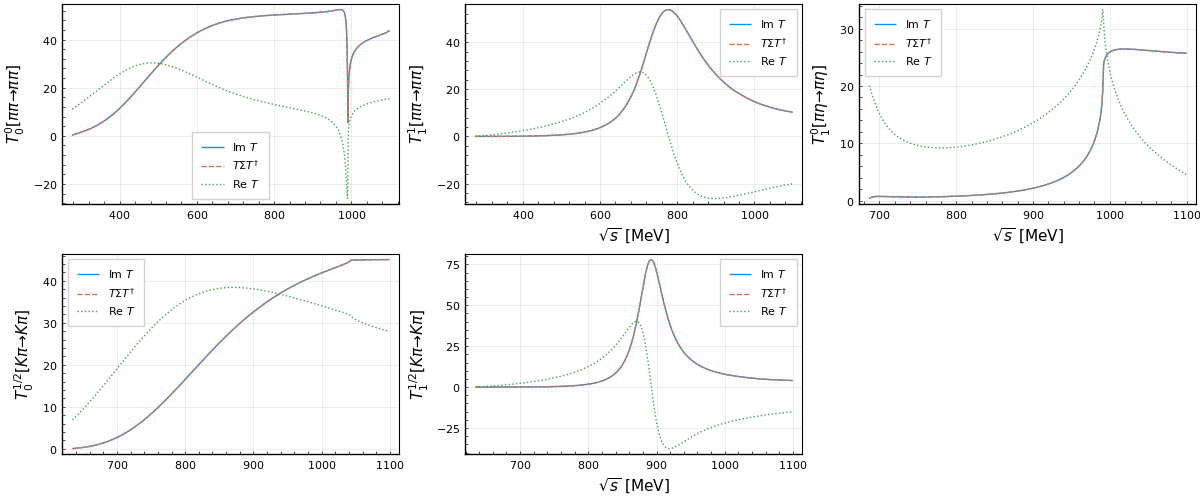

In [268]:
plt_unitarity(args(fit_pc) )

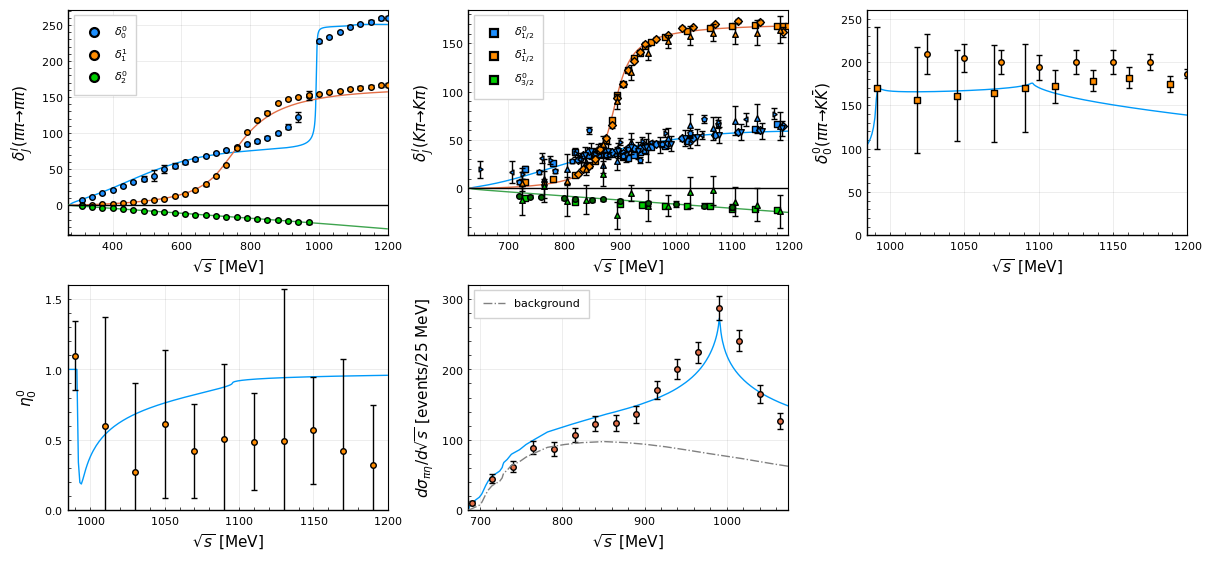

  0.984970 seconds (142.00 k allocations: 7.745 MiB)


In [308]:
@time plt_compare(args(fit_pc), jump = 950)
savefig("iam_bestfit.pdf")

In [ ]:
@time parasdf_plus5pc = contour_df(fit_pc, χsq_pc, npts = 10)

In [ ]:
CSV.write("paras_plus5pc_mncount.csv", parasdf_plus5pc)

In [209]:
parasdf_plus5pc = DataFrame!(CSV.File("paras_plus5pc_mncount.csv"));

In [ ]:
# pick out the parameter sets with χ² smaller than the best fit, suspected to given unphysical singularity at some point, changing χ² in the 00 channel abruptly
suspected = parasdf_plus5pc[parasdf_plus5pc.χ² .<406.4, :];
physical_candidates = parasdf_plus5pc[parasdf_plus5pc.χ² .>=406.4, :];

In [ ]:
plt_compare(suspected[1,:][2:end], jump = 900)

In [ ]:
pyplot()
@time plt_paras(parasdf_plus5pc .* 1e3)

In [ ]:
@time plt_paras(suspected .* 1e3)

In [ ]:
@time plt_paras(physical_candidates .* 1e3)

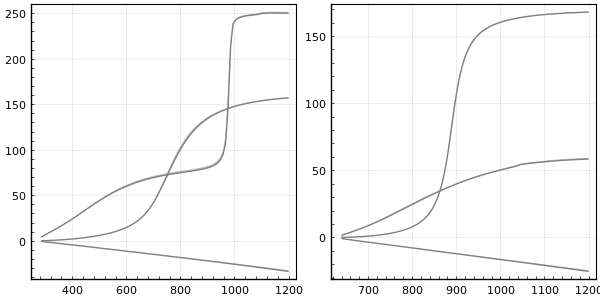

In [212]:
pyplot()
# it turns out that all the parameter sets in physical_candidates do not have unphysical singularities
let p1, p2
    p1 = plt_band(physical_candidates, ππ, (x, p)->δ00(x,p, jump=900))
    plt_band!(physical_candidates, ππ, δ11)
    plt_band!(physical_candidates, ππ, δ20)
    p2 = plt_band(physical_candidates, Kπ, δhalf0)
    plt_band!(physical_candidates, Kπ, δhalf1)
    plt_band!(physical_candidates, Kπ, δ3half0)
    plot(p1, p2, size=(600,300))
end

In [ ]:
CSV.write("paras_plus5pc_physical.csv", physical_candidates)

In [252]:
function plt_compare2(lec, bands::DataFrame=physical_candidates; jump = 920)
    _lec = Ref(lec); _lec0 = Ref(lecr0); _paras = bands;
    wv = 270:1.0:1200
    p1 = plot(wv, δ00.(wv, _lec; jump = jump), line=:dot, label="", xlim = (wv[1], wv[end]))
    plt_band!(_paras, ππ, (x, p)->δ00(x,p, jump=920), color=:dodgerblue)
    plot!(wv, δ11.(wv, _lec), line=:dot, color=:darkorange, label="" )
    plt_band!(_paras, ππ, δ11, color=:darkorange)
    plot!(wv, δ20.(wv, _lec), label="", color=:green3, line=:dot )
    plt_band!(_paras, ππ, δ20, color=:green3)
    plot!(wv, δ00.(wv, _lec0; jump = jump), label="", line=:dash, color=:dodgerblue  )
    plot!(wv, δ11.(wv, _lec0), label="", line=:dash, color=:darkorange )
    plot!(wv, δ20.(wv, _lec0), label="", line=:dash, color=:green3)
    @plt_data! data_ππ00 label = L"\delta_{0}^0" marker = (:circle, :dodgerblue)
    @plt_data! data_ππ11 label = L"\delta_{1}^1" marker = (:circle, :darkorange)
    @plt_data! data_ππ20 label = L"\delta_{0}^2" marker = (:circle, :green3) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (\pi\pi\to \pi\pi)"
    hline!([0], color = :black, label=:none)    
    
    xv = 630:1.0:1200
    p2 = plot(xv, δhalf0.(xv, _lec), line=:dot, label="", xlim = (xv[1], xv[end]))
    plt_band!(_paras, Kπ, δhalf0, color=:dodgerblue)
    plot!(xv, δhalf1.(xv, _lec), line=:dot, label="" )
    plt_band!(_paras, Kπ, δhalf1, color=:darkorange)
    plot!(xv, δ3half0.(xv, _lec), line=:dot, label="" )
    plt_band!(_paras, Kπ, δ3half0, color=:green3)
    plot!(wv, δhalf0.(wv, _lec0), label="", line=:dash, color=:dodgerblue  )
    plot!(wv, δhalf1.(wv, _lec0), label="", line=:dash, color=:darkorange )
    plot!(wv, δ3half0.(wv, _lec0), label="", line=:dash, color=:green3)
    plot!(wv, δhalf0.(wv, _lec0), label="", line=:dash, color=:dodgerblue  )
    plot!(wv, δhalf1.(wv, _lec0), label="", line=:dash, color=:darkorange )
    plot!(wv, δ3half0.(wv, _lec0), label="", line=:dash, color=:green3)
    @plt_data! Data(data_πK10_Estabrooks_df)[1:19] label = L"\delta^{1/2}_0" marker = (:rect, :dodgerblue)
    @plt_data! Data(data_πK10_Aston_df)[1:21] label = "" marker = (:diamond, :dodgerblue)
    @plt_data! Data(data_πK10_Mercer_df)[1:14] label = "" marker = (:utriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Bingham_df)[1:19] label = "" marker = (:dtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_Baker_df) label = "" marker = (:pentagon, :dodgerblue)
    @plt_data! Data(data_πK10_BES_df) label = "" marker = (:rtriangle, :dodgerblue)
    @plt_data! Data(data_πK10_BaBar_df) label = "" marker = (:ltriangle, :dodgerblue)
    
    @plt_data! Data(data_πK11_Estabrooks_df)[1:23] label = L"\delta^{1/2}_1" marker = (:rect, :darkorange)
    @plt_data! Data(data_πK11_Aston_df)[1:21] label = "" marker = (:diamond, :darkorange)
    @plt_data! Data(data_πK11_Mercer_df)[1:14] label = "" marker = (:utriangle, :darkorange)
 
    @plt_data! Data(data_πK30_Estabrooks_df)[1:10] label = L"\delta^{3/2}_0" marker = (:rect, :green3)
    @plt_data! Data(data_πK30_Mercer_df)[1:14] label="" marker = (:utriangle, :green3)
    @plt_data! Data(data_πK30_Lingin_df) label="" marker=(:circle, :green3) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{J}^I (K\pi\to K \pi)"
    hline!([0], color = :black, label=:none)   
    
    wv2 = 985:1.0:1200
    p3 = plot(wv2, δππkk00.(wv2, _lec), line=:dot, label = "", xlim = (wv2[1], wv2[end]), ylim=(0,260) )
    plt_band!(_paras, KK, δππkk00, color=:dodgerblue)
    plot!(wv2, δππkk00.(wv2, _lec0), label="", line=:dash, color=:dodgerblue)
    @plt_data! Data(data_ππkk00_Cohen_df) label = "" marker = :dodgerblue
    @plt_data! Data(data_ππkk00_Martin_df)[1:9] label="" marker=(:rect,:dodgerblue) xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\delta_{0}^0 (\pi\pi\to K \bar K)"
       
    p4 = plot(wv2, η00.(wv2, _lec), line=:dot, legend = :none, xlim = (wv2[1], wv2[end]), ylim=(0, 1.6))
    plt_band!(_paras, KK, η00, color=:dodgerblue)
    plot!(wv2, η00.(wv2, _lec0), label="", line=:dash, color=:dodgerblue)
    @plt_data! data_ππ00_eta marker = :dodgerblue xlab=L"\sqrt{s}"*" [MeV]" ylab = L"\eta_{0}^0" # label = L"\eta_{0}^0"
    
    plot(p1, p2, p3, p4, size=(800,500))
end

plt_compare2 (generic function with 2 methods)

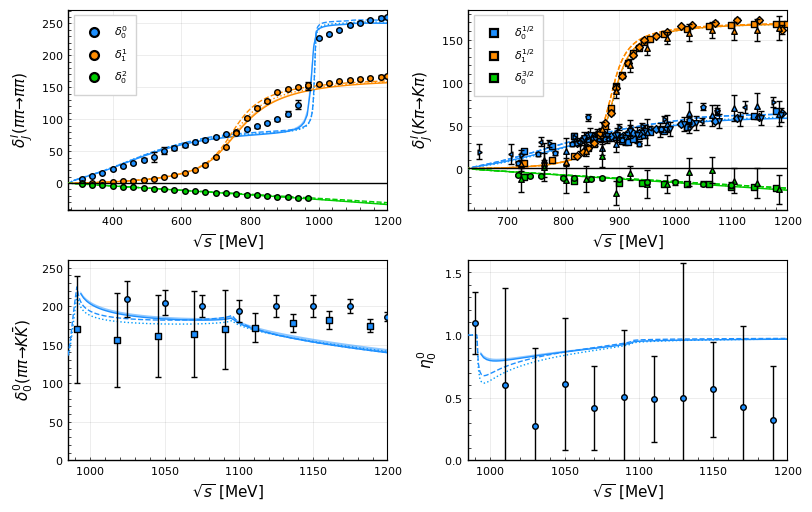

 26.631380 seconds (5.85 M allocations: 289.980 MiB, 0.56% gc time)


In [253]:
@time plt_compare2(args(fit0), physical_candidates)
savefig("iam_bestfit.pdf") #, bbox_inches="tight", pad_inches=0

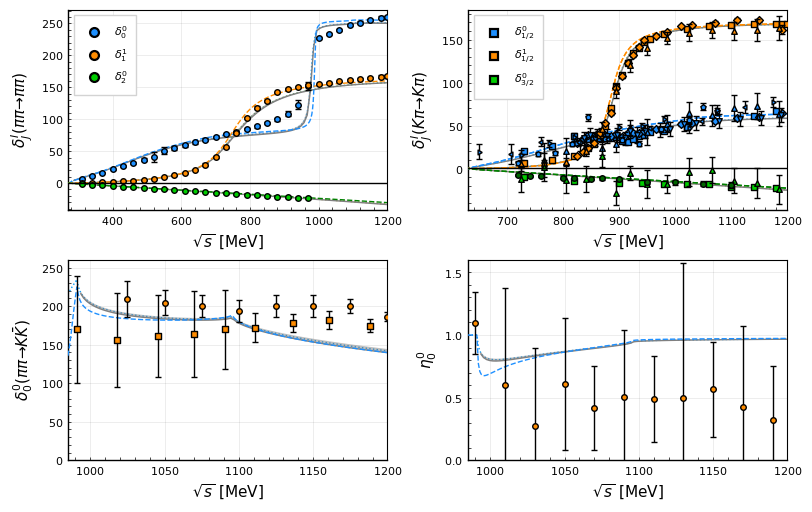

 27.918892 seconds (6.14 M allocations: 305.457 MiB, 0.51% gc time)


In [242]:
@time plt_compare2(args(fit_pc), physical_candidates)
# savefig("iam_bestfit.pdf") #, bbox_inches="tight", pad_inches=0

In [220]:
# expars = map(extrema, eachcol(physical_candidates))
let _pars = map(extrema, eachcol(physical_candidates))
    [_pars[i+1] .- args(fit_pc)[i] for i in 1:8 ]
end

8-element Array{Tuple{Float64,Float64},1}:
 (-1.7367758932303732e-5, 1.7145514100609834e-5)
 (-2.9214204294761726e-5, 2.9732186908630045e-5)
 (-3.372597956955402e-5, 3.34140334097505e-5)
 (-1.8498037432686926e-5, 1.3834664396439019e-5)
 (-0.0005874329698295152, 0.0005809669640917284)
 (0.0, 0.0)
 (-0.00018929798340234388, 0.0001920408528551104)
 (-0.0003446415155060861, 0.00031044441205349527)

In [221]:
let _pars = map(extrema, eachcol(parasdf_plus5pc))
    [_pars[i+1] .- args(fit_pc)[i] for i in 1:8 ]
end

8-element Array{Tuple{Float64,Float64},1}:
 (-1.7367758932303732e-5, 1.7145514100609834e-5)
 (-2.9214204294761726e-5, 2.9732186908630045e-5)
 (-3.372597956955402e-5, 3.34140334097505e-5)
 (-1.8498037432686926e-5, 1.3834664396439019e-5)
 (-0.0005874329698295152, 0.0005809669640917284)
 (0.0, 0.0)
 (-0.00018929798340234388, 0.0001920408528551104)
 (-0.0003446415155060861, 0.00033801936462492656)

### with increased errors except for those from DR analysis

In [44]:
add_moreerr = 0.1;

In [42]:
χsq_pc_00(pars) = chisq_ps(δ00_0, data_ππ00, pars )
χsq_pc_11(pars) = chisq_ps(δ11, data_ππ11, pars ) 
χsq_pc_20(pars) = chisq_ps(δ20, data_ππ20, pars )
χsq_pc_η00(pars) = chisq(η00, weight(data_ππ00_eta, add_moreerr), pars );
χsq_pc_ππkk00(pars) = chisq_ps(δππkk00, weight(data_ππKK00, add_moreerr), pars )

χsq_pc_half0(pars) = chisq_ps(δhalf0, weight(data_πK10, add_moreerr), pars)
χsq_pc_half1(pars) = chisq_ps(δhalf1, weight(data_πK11, add_moreerr), pars)
χsq_pc_3half0(pars) = chisq_ps(δ3half0, weight(data_πK30, add_moreerr), pars);

In [45]:
@show_individual_pc lecr0

χ^2/dof in 00:  31.28688435985907
χ^2/dof in 11:  20.152963885185276
χ^2/dof in 20:  2.1305958806830825
χ^2/dof in half0:  1.2309336395486354
χ^2/dof in half1:  0.894011871225215
χ^2/dof in 3half0:  1.5735508956556652
χ^2/dof in ππkk00:  1.2555078434120426
χ^2/dof in η00:  0.46404013545534717
Total χ^2/dof:   4.662332622126572


In [46]:
@show_individual_pc lec_best_plus5pc

χ^2/dof in 00:  26.925764595942564
χ^2/dof in 11:  26.99783162187684
χ^2/dof in 20:  0.5989372456622774
χ^2/dof in half0:  0.7403584033758365
χ^2/dof in half1:  0.49582282011830286
χ^2/dof in 3half0:  1.4020991588661933
χ^2/dof in ππkk00:  1.1580609114169356
χ^2/dof in η00:  0.46120510147117594
Total χ^2/dof:   4.543353657650626


In [50]:
χsq_pc(pars) = (χsq_pc_00(pars)  + χsq_pc_11(pars) + χsq_pc_20(pars) + χsq_pc_ππkk00(pars) + χsq_pc_η00(pars)
#              + χsq_pc_half0(pars) + χsq_pc_half1(pars) + χsq_pc_3half0(pars)
    )
fit_pc = Minuit(χsq_pc, lec_best0, error=1e-6*ones(8), name = name,
     fix_L1=false, fix_L3=false, fix_L4=false, fix_L5=false, fix_L6=true, fix_L7=false, fix_L8=false
)
fit_pc.strategy = 2;

In [51]:
@time migrad(fit_pc)

 22.928121 seconds (67.18 k allocations: 3.574 MiB)


PyObject MigradResult(fmin=FMin(fval=422.27222293080894, edm=3.750874370685851e-05, tolerance=0.1, nfcn=987, ncalls=987, up=1.0, is_valid=True, has_valid_parameters=True, has_accurate_covar=False, has_posdef_covar=False, has_made_posdef_covar=True, hesse_failed=False, has_covariance=True, is_above_max_edm=False, has_reached_call_limit=False), params=[Param(number=0, name='L1', value=0.0012307664308069915, error=2.2743543208285897e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=1, name='L2', value=0.0013351657329115521, error=1.1130065959871132e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=2, name='L3', value=-0.0040248467010688405, error=3.1442187551649444e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=3, name='L4', value=1.2032337651583951e-06, error=1.2816752636733182e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=4, name='L5', value=-0.001494203059818866, error=8.255028939582626e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=5, name='L6', value=7.000000000000001e-05, error=1e-06, is_const=False, is_fixed=True, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=6, name='L7', value=0.0001227483056941221, error=1.5913276881990414e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None), Param(number=7, name='L8', value=-0.0006163782807825417, error=3.7555290879002866e-05, is_const=False, is_fixed=False, has_limits=False, has_lower_limit=False, has_upper_limit=False, lower_limit=None, upper_limit=None)])

In [52]:
@show_individual_pc args(fit_pc)

χ^2/dof in 00:  7.758489768279961
χ^2/dof in 11:  4.084938656125771
χ^2/dof in 20:  7.821757667624453
χ^2/dof in half0:  0.779126418102444
χ^2/dof in half1:  26.41979353838933
χ^2/dof in 3half0:  1.8505726012534585
χ^2/dof in ππkk00:  0.6348472777822324
χ^2/dof in η00:  0.2840584906633822
Total χ^2/dof:   5.894858493673446


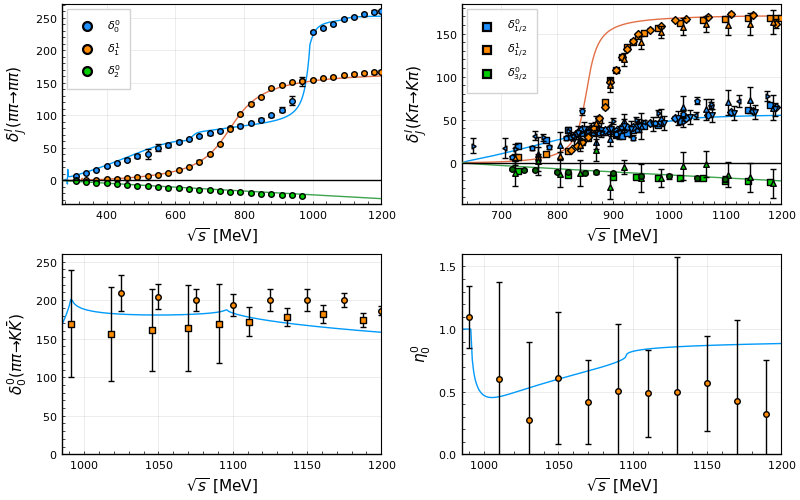

In [54]:
plt_compare(args(fit_pc), jump = 850)